In [1]:
# Parameters
annotated_data_path = "/maps/projects/dan1/people/bns631/HypoAtlas/DataProcessing_pipeline/Data/RawZhou/zhou_annotations.RDS"
raw_read_path = "/maps/projects/dan1/people/bns631/HypoAtlas/DataProcessing_pipeline/Data/RawZhou"



Author: Erno Hänninen

Created: 2023-06-02

Title: AnnotateHerbData.ipynb

Description:
 - Filters and annotates cell types to the raw timepoint data from Herb paper
 
Procedure:
 - ...

List of non-standard modules:
 - scanpy


In [2]:
import scanpy as sc
import scib
import os
# os.environ[“MY_ENV_VAR”]
os.environ["MKL_NUM_THREADS"] = "15"
os.environ["NUMEXPR_NUM_THREADS"] = "15"
os.environ["OMP_NUM_THREADS"] = "15"

During startup - Warning messages:
1: Setting LC_TIME failed, using "C" 
2: Setting LC_MONETARY failed, using "C" 
3: Setting LC_PAPER failed, using "C" 
4: Setting LC_MEASUREMENT failed, using "C" 


## Load and explore the integrated Herb data

The integrated Herb data is produced in this script: https://github.com/brianherb/HumanHypothalamusDev/blob/f87a2788cef62b55f6c66ba343634673ba30042a/Fig1_HumanEmbryonic.R 

In [3]:
#Read the annotated data (annotated by Yuan)
adata_processed  = scib.pp.read_seurat(annotated_data_path)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:351: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:351: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(
/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/anndata2ri/r2py.py:106: Fu

In [4]:
adata_processed

AnnData object with n_obs × n_vars = 122429 × 25058
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.hemo', 'cellBatch', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'seurat_clusters', 'SCT_snn_res.0.1', 'SCT_snn_res.0.3', 'tempClr', 'cellType', 'cellType2', 'ident'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

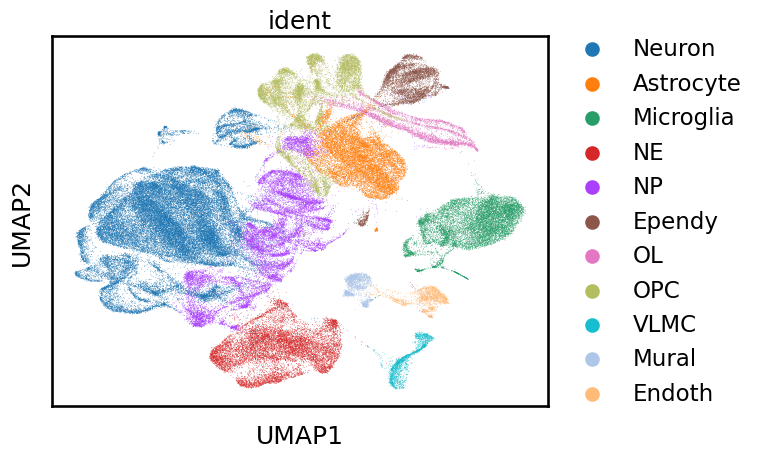

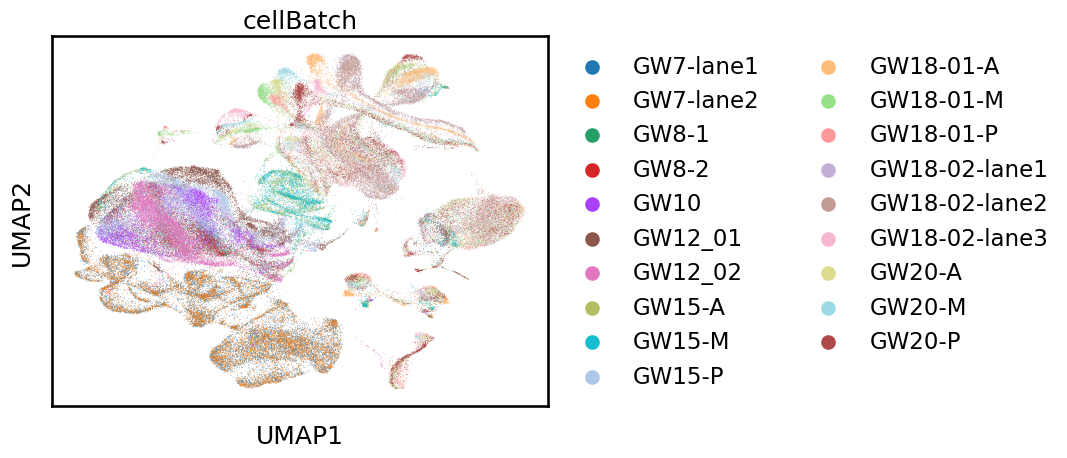

In [5]:
# Plot the celltypes and timpointe
sc.pl.umap(adata_processed, color="ident")
sc.pl.umap(adata_processed, color="cellBatch")

## Filter, annotate and process raw data

In [6]:
#Read the raw matrixes
adata_raw = sc.read_10x_mtx(raw_read_path, prefix="GSE169109_") #.gz files
adata_raw

AnnData object with n_obs × n_vars = 135731 × 32738
    var: 'gene_ids', 'feature_types'

In [7]:
#Raw data processing
#Gene filtering
shared_genes = adata_processed.var_names.intersection(adata_raw.var_names) #Takes the intersection of genes
shared_genes
adata_raw = adata_raw[:, shared_genes].copy() #Do the actual filtering

In [8]:
#Cell filtering
shared_cells = adata_processed.obs_names.intersection(adata_raw.obs_names) #Takes the intersection of cells

adata_raw = adata_raw[shared_cells,:].copy() #Do the actual filtering

adata_filtered = adata_raw.copy()

In [9]:
#Rename columns
adata_filtered.obs["Cell_types"] = adata_processed.obs["ident"]
adata_filtered.obs["sample"] = adata_processed.obs["cellBatch"]

In [10]:
adata_filtered

AnnData object with n_obs × n_vars = 122429 × 24996
    obs: 'Cell_types', 'sample'
    var: 'gene_ids', 'feature_types'

In [11]:
#Write the processed data to file
adata_filtered.write("Processed_zhou_adata.h5ad")